This notebook was used to combine the results of the trained CNN models and analyze the results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import (
    roc_auc_score, f1_score, confusion_matrix,
    plot_precision_recall_curve, plot_roc_curve)

from sklearn.metrics import (
    roc_auc_score, f1_score, balanced_accuracy_score,
    average_precision_score, precision_recall_curve,
    confusion_matrix, auc, roc_curve,
    plot_precision_recall_curve, plot_roc_curve,
    recall_score, precision_score, auc)

from cf_matrix import make_confusion_matrix
from data_io import get_data, balance_out
from data_representation import (
    kmer_counts, one_hot_encoding, kmer_embeddings)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [2]:
k = 1
species = 'human'
form = 'split'
kmer_representation = 'dense'

In [ ]:
X_val_raw, y_val = get_data(species, form=form, mode='val', k=k)

In [ ]:
X_test_raw, y_test = get_data(species, form=form, mode='test', k=k)

In [ ]:
X_hidden_raw, _ = get_data(species, form=form, mode='hidden', k=k)

In [6]:
y_val[y_val < 0] = 0
y_test[y_test < 0] = 0

### Representation

In [ ]:
X_val_1_hot = one_hot_encoding(X_val_raw, k=k,form='2d')
X_test_1_hot = one_hot_encoding(X_test_raw, k=k,form='2d')
X_hidden_1_hot = one_hot_encoding(X_hidden_raw, k=k,form='2d')

X_val_dense = kmer_embeddings(X_val_raw, k=6, to_split=True)
X_test_dense = kmer_embeddings(X_test_raw, k=6, to_split=True)
X_hidden_dense = kmer_embeddings(X_hidden_raw, k=6, to_split=True)

In [ ]:
print(X_val_1_hot.shape)
print(X_test_1_hot.shape)
print(X_hidden_1_hot.shape)

In [ ]:
cy_val = to_categorical(y_val)
cy_test = to_categorical(y_test)

### Predictions

Here, predictions for each of the trained models were made on all 3 non-training data sets. The results were stored for later averaging.

In [ ]:
model_names_1_hot = [
	'submit_keras_cnn_1_hot_0.model',
	'submit_keras_cnn_1_hot_1.model',
	'submit_keras_cnn_1_hot_10.model',
	'submit_keras_cnn_1_hot_11.model',
	'submit_keras_cnn_1_hot_12.model',
	'submit_keras_cnn_1_hot_13.model',
	'submit_keras_cnn_1_hot_14.model',
	'submit_keras_cnn_1_hot_2.model',
	'submit_keras_cnn_1_hot_3.model',
	'submit_keras_cnn_1_hot_4.model'
]

model_names_dense = [
	'submit_keras_cnn_dense_0.model',
	'submit_keras_cnn_dense_1.model',
	'submit_keras_cnn_dense_10.model',
	'submit_keras_cnn_dense_11.model',
	'submit_keras_cnn_dense_2.model',
	'submit_keras_cnn_dense_20.model',
	'submit_keras_cnn_dense_21.model',
	'submit_keras_cnn_dense_22.model',
	'submit_keras_cnn_dense_23.model',
	'submit_keras_cnn_dense_24.model',
	'submit_keras_cnn_dense_3.model'
]

In [ ]:
model_categories = [model_names_1_hot, model_names_dense]

In [13]:
for ii, model_names in enumerate(model_categories):
    
    category = '1-hot' if ii == 0 else 'dense'
    
    X_val = X_val_1_hot if ii == 0 else X_val_dense
    X_test = X_test_1_hot if ii == 0 else X_test_dense
    X_hidden = X_hidden_1_hot if ii == 0 else X_hidden_dense
    
    for model_name in model_names:

        model = keras.models.load_model(model_name)

        model_no = model_name.split('_')[-1].split('.')[0]

        y_pred_val = model.predict(X_val)
        y_probs_val = y_pred_val[:, 1]

        y_pred_test = model.predict(X_test)
        y_probs_test = y_pred_test[:, 1]

        y_pred_hidden = model.predict(X_hidden)
        y_probs_hidden = y_pred_hidden[:, 1]

        pd.DataFrame(y_probs_val).to_csv(
            f'./predictions/proba_val_human_cnn_{category}_m{model_no}.csv')
        pd.DataFrame(y_probs_test).to_csv(
            f'./predictions/proba_test_human_cnn_{category}_m{model_no}.csv')
        pd.DataFrame(y_probs_hidden).to_csv(
            f'./predictions/proba_hidden_human_cnn_{category}_m{model_no}.csv')

## Ensemble

We take each models' predictions and average them to obtain the final results

In [7]:
pred_files_val = np.asarray([
    'proba_val_human_cnn_1-hot_m0.csv',
    'proba_val_human_cnn_1-hot_m10.csv',
    'proba_val_human_cnn_1-hot_m11.csv',
    'proba_val_human_cnn_1-hot_m12.csv',
    'proba_val_human_cnn_1-hot_m13.csv',
    'proba_val_human_cnn_1-hot_m14.csv',
    'proba_val_human_cnn_1-hot_m1.csv',
    'proba_val_human_cnn_1-hot_m2.csv',
    'proba_val_human_cnn_1-hot_m3.csv',
    'proba_val_human_cnn_1-hot_m4.csv',
    'proba_val_human_cnn_dense_m0.csv',
    'proba_val_human_cnn_dense_m10.csv',
    'proba_val_human_cnn_dense_m11.csv',
    'proba_val_human_cnn_dense_m1.csv',
    'proba_val_human_cnn_dense_m20.csv',
    'proba_val_human_cnn_dense_m21.csv',
    'proba_val_human_cnn_dense_m22.csv',
    'proba_val_human_cnn_dense_m23.csv',
    'proba_val_human_cnn_dense_m24.csv',
    'proba_val_human_cnn_dense_m2.csv',
    'proba_val_human_cnn_dense_m3.csv'
])

pred_files_test = np.asarray([
    'proba_test_human_cnn_1-hot_m0.csv',
    'proba_test_human_cnn_1-hot_m10.csv',
    'proba_test_human_cnn_1-hot_m11.csv',
    'proba_test_human_cnn_1-hot_m12.csv',
    'proba_test_human_cnn_1-hot_m13.csv',
    'proba_test_human_cnn_1-hot_m14.csv',
    'proba_test_human_cnn_1-hot_m1.csv',
    'proba_test_human_cnn_1-hot_m2.csv',
    'proba_test_human_cnn_1-hot_m3.csv',
    'proba_test_human_cnn_1-hot_m4.csv',
    'proba_test_human_cnn_dense_m0.csv',
    'proba_test_human_cnn_dense_m10.csv',
    'proba_test_human_cnn_dense_m11.csv',
    'proba_test_human_cnn_dense_m1.csv',
    'proba_test_human_cnn_dense_m20.csv',
    'proba_test_human_cnn_dense_m21.csv',
    'proba_test_human_cnn_dense_m22.csv',
    'proba_test_human_cnn_dense_m23.csv',
    'proba_test_human_cnn_dense_m24.csv',
    'proba_test_human_cnn_dense_m2.csv',
    'proba_test_human_cnn_dense_m3.csv'
])

pred_files_hidden = np.asarray([
    'proba_hidden_human_cnn_1-hot_m0.csv',
    'proba_hidden_human_cnn_1-hot_m10.csv',
    'proba_hidden_human_cnn_1-hot_m11.csv',
    'proba_hidden_human_cnn_1-hot_m12.csv',
    'proba_hidden_human_cnn_1-hot_m13.csv',
    'proba_hidden_human_cnn_1-hot_m14.csv',
    'proba_hidden_human_cnn_1-hot_m1.csv',
    'proba_hidden_human_cnn_1-hot_m2.csv',
    'proba_hidden_human_cnn_1-hot_m3.csv',
    'proba_hidden_human_cnn_1-hot_m4.csv',
    'proba_hidden_human_cnn_dense_m0.csv',
    'proba_hidden_human_cnn_dense_m10.csv',
    'proba_hidden_human_cnn_dense_m11.csv',
    'proba_hidden_human_cnn_dense_m1.csv',
    'proba_hidden_human_cnn_dense_m20.csv',
    'proba_hidden_human_cnn_dense_m21.csv',
    'proba_hidden_human_cnn_dense_m22.csv',
    'proba_hidden_human_cnn_dense_m23.csv',
    'proba_hidden_human_cnn_dense_m24.csv',
    'proba_hidden_human_cnn_dense_m2.csv',
    'proba_hidden_human_cnn_dense_m3.csv'
])

In [9]:
preds_val, preds_test, preds_hidden = [], [], []

val_scores, test_scores = [], []

for f in pred_files_val:
    ps = pd.read_csv(f'./predictions/cnn_individual_models/{f}')
    preds_val.append(ps['0'].to_numpy())
    val_scores.append(average_precision_score(y_val, ps['0'].to_numpy()))

for f in pred_files_test:
    ps = pd.read_csv(f'./predictions/cnn_individual_models/{f}')
    preds_test.append(ps['0'].to_numpy())
    test_scores.append(average_precision_score(y_test, ps['0'].to_numpy()))
    
for f in pred_files_hidden:
    ps = pd.read_csv(f'./predictions/cnn_individual_models/{f}')
    preds_hidden.append(ps['0'].to_numpy())

#### Examination

In [10]:
val_scores = np.asarray(val_scores)
test_scores = np.asarray(test_scores)

In [11]:
print(val_scores[np.argsort(val_scores)])
print(test_scores[np.argsort(test_scores)])

[0.00255003 0.24533462 0.25221897 0.28284551 0.29228803 0.30721046
 0.31691169 0.31931336 0.32168459 0.32176959 0.32469433 0.33003719
 0.33316228 0.35015745 0.35447714 0.3591608  0.37109458 0.37252987
 0.37800455 0.39714333 0.4225955 ]
[0.00312003 0.38453995 0.40821516 0.42201209 0.42334046 0.42612461
 0.43181256 0.43496964 0.43732642 0.43986597 0.44504237 0.4468902
 0.44800109 0.45119758 0.46451524 0.4661517  0.46641868 0.47678358
 0.49058167 0.49134615 0.50675261]


In [12]:
args = np.argsort(val_scores)

We discard the worst 5 predictions since not all models converged well

#### Predictions

In [14]:
preds_val = np.array(preds_val)
preds_test = np.array(preds_test)
preds_hidden = np.array(preds_hidden)

We only keep the predictions of the high-scoring models

In [15]:
preds_val = preds_val[args[5:], :]
preds_test = preds_test[args[5:], :]
preds_hidden = preds_hidden[args[5:], :]

In [16]:
y_preds_val_ensemble = np.mean(preds_val, axis=0)
y_preds_test_ensemble = np.mean(preds_test, axis=0)
y_preds_hidden_ensemble = np.mean(preds_hidden, axis=0)

We examine the metrics on the validation and the test data sets

In [17]:
print(f'AUROC = {roc_auc_score(y_val, y_preds_val_ensemble)}.')
print(f'AUPRC = {average_precision_score(y_val, y_preds_val_ensemble)}.')

AUROC = 0.9722541470871313.
AUPRC = 0.4709979384600259.


In [18]:
print(f'AUROC = {roc_auc_score(y_test, y_preds_test_ensemble)}.')
print(f'AUPRC = {average_precision_score(y_test, y_preds_test_ensemble)}.')

AUROC = 0.981317002988585.
AUPRC = 0.6071560461069506.


#### Plots

[Text(0.5, 0, 'Recall\n\nPRC AUC=0.6072'),
 Text(0, 0.5, 'Precision'),
 Text(0.5, 1.0, 'PR Curve')]

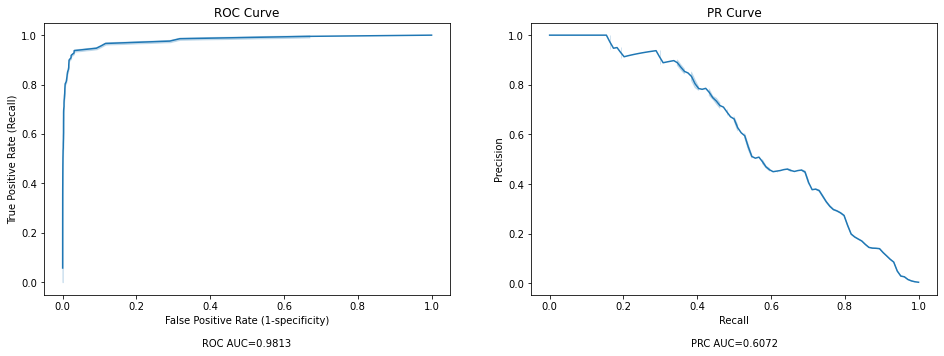

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

fpr, tpr, tresh_roc = roc_curve(y_test.ravel(), y_preds_test_ensemble.ravel())
precision, recall, tresh_roc = precision_recall_curve(y_test.ravel(), y_preds_test_ensemble.ravel())

roc_auc = roc_auc_score(y_test, y_preds_test_ensemble)
prc_auc = average_precision_score(y_test, y_preds_test_ensemble)

sns.lineplot(ax=axes[0], x=fpr, y=tpr)
axes[0].set(xlabel='False Positive Rate (1-specificity)' + '\n\nROC AUC={:0.4f}'.format(roc_auc), ylabel='True Positive Rate (Recall)', title='ROC Curve')

sns.lineplot(ax=axes[1], x=recall, y=precision)
axes[1].set(xlabel='Recall'+ '\n\nPRC AUC={:0.4f}'.format(prc_auc), ylabel='Precision' , title='PR Curve')

#### Store results

In [ ]:
pd.DataFrame(y_preds_hidden_ensemble).to_csv(
    "./predictions/proba_human_hidden_cnn_ensemble_submit.csv")

In [20]:
pd.DataFrame(y_preds_test_ensemble).to_csv(
    "./predictions/proba_human_test_cnn_ensemble_submit.csv")

In [21]:
pd.DataFrame(y_preds_val_ensemble).to_csv(
    "./predictions/proba_human_val_cnn_ensemble_submit.csv")